Firstly, import the fortran disk model routines and the python likelihood functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import emcee

Load a continuum subtracted spectrum. In the example of ZTF19aagwzod, I haven't done continuum subtraction so I'm subtracting the baseline, but you should do this beforehand. Define the redshift of the source (this can be a fitted parameter later, but you need a good initial guess.

In [2]:
fn =  '../data/ZTF18aahiqst_subtracted.txt'#'../data/at2020afhd-hal-20240214.158%2Berr.flm'#ZTF20abwtifz.ascii' #Another example at '../data/ZTF18aahiqst_subtracted.txt'
wl,flux,fluxerr = utils.readspec(fn)
#flux=flux-np.median(flux[:10])+10 #Subtract the baseline here if you need, but better to do this properly beforehand
z = 0.0745#0.029#0.0702 #0.0745 # Redshift

Extract the region of the spectrum containing the double-peaked profile, and store the size of the spectrum in npix

In [3]:
olambda = 6564.614#6563 # nominal wavelength of the Halpha line (Angstrom)
wavemin = 6340  # minimum rest wavelength (Angstrom)
wavemax = 6800  # maximum rest wavelength (Angstrom)
wave = wl/(1+z) # Convert the spectrum to rest frame wavelength
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]


Set all the parameters which will remain fixed to pre-determined values during the fitting

In [4]:
# Integration, units, normalization

maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]
# Circular disk size and emission properties

q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-8   # optical depth normalization (0=no wind)
eta = 0.8 #optical depth power-law index
anglam = 8 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
amp = 1e-12 #contrast of spiral arm (0=no arms)
narms = 1 #number of arms (integer)
aobs = 95 #spiral orientation (degrees, +ve=outer, -ve=inner)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 0 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 0 #outer spiral arm radius radius (GM/c^2, 0=XI2)

#Narrow lines
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

#Broadline
broadwidth= 80
broadHalphaflux=3

In [5]:
# Bounds on parameters
angimax = 360                                                                       
angimin= -360                                                                       
xi1min = 50                                                                         
xi1max = 10000                                                                       
xi2min = 100                                                                        
xi2max = 10000                                                                       
broadmin = 0                                                                        
broadmax = 2000                                                                                                                                            
ampmin = -1e-12                                                                        
ampmax = 5.0                                                                        
pitchmin = -60                                                                      
pitchmax = 60                                                                       
aobsmin = -720                                                                      
aobsmax = 360*3 
narrowwidthmin=0.1
narrowwidthmax=15.0
narrowwidth2min = 0.1
narrowwidth2max = 12.0
narrowfracmin = 0.1
narrowfracmax = 5.0
broadwidthmax=500
broadwidthmin=20
anglammin=2.0
anglammax=40
t0min=1e-10
t0max=1e2
etamin=-1.5
etamax=1.5
Halphafluxmin=12
Halphafluxmax=300
NIIbfluxmin=0.0
NIIbfluxmax=8
SIIbfluxmin=0.0
SIIbfluxmax=300
diskfluxmin=1
diskfluxmax=500
broadHalphafluxmin=0.0
broadHalphafluxmax=300

Set wavelengths of narrow emission lines to be included in the fit and create the array of line profiles. Set the ratios of any doublets.

In [24]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]#,OIa,OIb]
linesbroad = [Halpha]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
OIb_OIa = 0.33
ratios = [NIIb_NIIa,SIIb_SIIa]#,OIb_OIa]
#Guess narrow line fluxes
Halphaflux = 25
NIIbflux = 5
diskflux = 6
SIIbflux = 8
OIbflux = 0
broadHalphaflux=6.0

Create a dictionary of the fixed parameter names and values

In [25]:
fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','amp','narms','aobs','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,amp,narms,aobs,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix]
fixed = dict(zip(fixed_labels,fixed_values))

Set initial guesses for the parameters to be fitted

In [26]:
angi = 15 #disk inclination angle (degrees)
xi1 = 130 #inner disk radius (GM/c^2)
xi2 = 1000 #outer disk radius (multiple of xi1)
broad = 600 #broadening parameter (km/s)

Create a dictionary of fitted parameter names and values. We will fit for the widths of the two narrow line components and the ratio of those components, as well as 4 disk parameters.

In [27]:
fitted_labels = ['xi1','xi2','broad','angi','broadwidth','broadHalphaflux','narrowfrac','narrowwidth','narrowwidth2','anglam','t0','eta','Halphaflux','NIIbflux','SIIbflux','diskflux']
initial = [xi1,xi2,broad,angi,broadwidth,broadHalphaflux,narrowfrac,narrowwidth,narrowwidth2,anglam,t0,eta,Halphaflux,NIIbflux,SIIbflux,diskflux]
fitted = dict(zip(fitted_labels,initial))

In [28]:
diskmins = [xi1min,xi2min,broadmin,angimin,broadwidthmin,broadHalphafluxmin,narrowfracmin,narrowwidthmin,narrowwidth2min,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,SIIbfluxmin,diskfluxmin]
diskmax = [xi1max,xi2max,broadmax,angimax,broadwidthmax,broadHalphafluxmax,narrowfracmax,narrowwidthmax,narrowwidth2max,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,SIIbfluxmax,diskfluxmax]

In [29]:
for i,x in enumerate(initial):
    print(diskmins[i],x,diskmax[i])

50 130 10000
100 1000 10000
0 600 2000
-360 15 360
20 80 500
0.0 6.0 300
0.1 0.2 5.0
0.1 1.7 15.0
0.1 0.9 12.0
2.0 8 40
1e-10 1e-08 100.0
-1.5 0.8 1.5
12 25 300
0.0 5 8
0.0 8 300
1 6 500


Plot initial model against spectrum. We will use the circ_fixeddoublet class of models, which fit just the Halpha profile and use double Gaussians for the narrow lines. Line amplitudes are solved for automatically rather than fit as parameters.

In [30]:
modelguess = likelihood.model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)
disk,narrowlines,broadlines= likelihood.plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)

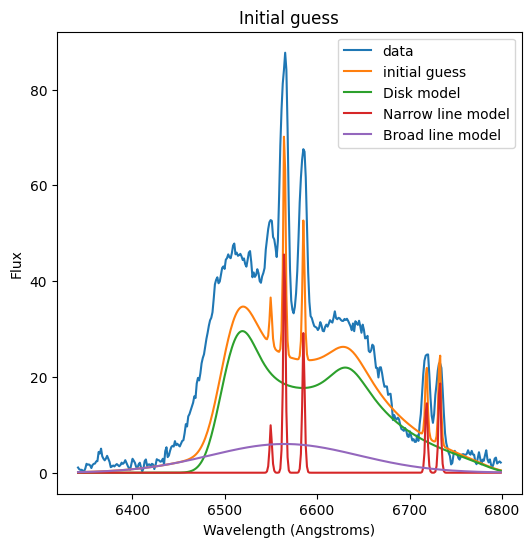

<Figure size 640x480 with 0 Axes>

In [31]:
plt.figure(figsize=(6,6))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelguess,label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='Broad line model')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Initial guess')
plt.legend()
plt.show()
plt.clf()

In [32]:
lp = likelihood.logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(wl, flux, fluxerr, lines, linesbroad, fixed, fitted, diskmins, diskmax)

Use scipy.optimize.minimize to find a simple solution for the fitted parameters

In [33]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values', soln.x)

Best-fit parameter values [5.70993115e+01 1.72790094e+03 7.73126297e+02 1.74926883e+01
 9.87429467e+01 1.69545754e-01 1.12274819e-01 3.97097578e+00
 1.33527335e+00 5.38302528e+00 1.10224294e-08 6.22498826e-01
 3.41545596e+01 7.74078400e+00 1.09704237e+01 5.62823227e+00]


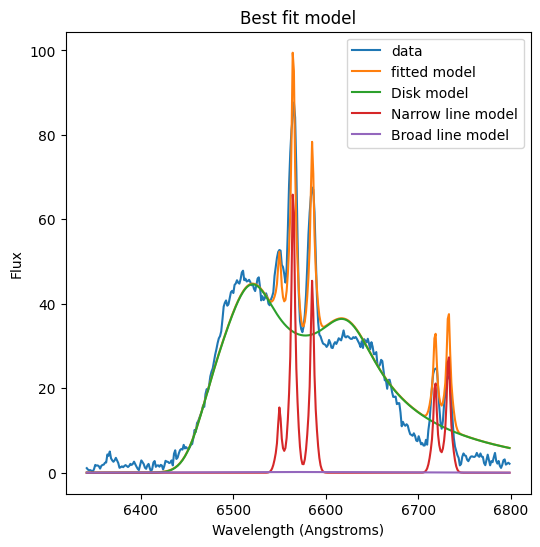

<Figure size 640x480 with 0 Axes>

In [34]:
disk,narrowlines,broadlines = lp.plot(soln.x)
plt.figure(figsize=(6,6))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,label='fitted model')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='Broad line model')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Best fit model')
plt.legend()
plt.show()
plt.clf()

Now import the emcee module to sample the parameter space, with walkers initialized around the best fit parameters from the previous step. Run the sampler for 1000 iterations and save the progress to file. If you get a singular matrix bug here, try changing the width of the priors.

In [35]:
#Distribute starting walkers to be very close to best-fit redshift but have more spread for disk parameters
#pos = np.column_stack((soln.x[:-1] + 5e-2 * soln.x[:-1] * np.random.randn(20, soln.x.shape[0]-1),soln.x[-1] + 1e-6 * soln.x[-1] * np.random.randn(20,1)))
pos = soln.x + 5e-1 * soln.x * np.random.randn(50, soln.x.shape[0])
nwalkers, ndim = pos.shape
filename ='emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 200, progress=True)

  0%|          | 0/200 [00:00<?, ?it/s]/home/cw1074/.conda/envs/scarlet/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [18:33<00:00,  5.57s/it]


State([[ 6.18067746e+01  1.67984551e+03  7.56953619e+02  1.74686244e+01
   1.39225569e+02  9.80470629e-02  1.42862585e-01  4.63538506e+00
   1.79268978e+00  3.70215196e+00  1.04681034e-08  5.56616785e-01
   2.97676153e+01  7.20405308e+00  8.04521367e+00  5.87026624e+00]
 [ 6.57894518e+01  1.84024949e+03  7.67305519e+02  1.74957086e+01
   1.17067805e+02  1.05549325e-01  1.53182105e-01  4.05933604e+00
   1.84863559e+00  4.44085748e+00  9.48454114e-09  5.34250073e-01
   3.14368618e+01  6.31568973e+00  8.78105140e+00  5.66444494e+00]
 [ 6.55209768e+01  1.76050266e+03  7.70849321e+02  1.78814722e+01
   1.35444607e+02  1.07631936e-01  1.49235718e-01  4.55438829e+00
   1.63391304e+00  4.06065113e+00  9.94094604e-09  5.52312830e-01
   3.15250161e+01  7.45300786e+00  8.68964457e+00  5.77332155e+00]
 [ 5.71350627e+01  1.79926240e+03  7.71832618e+02  1.73330404e+01
   1.14383276e+02  1.06740918e-01  1.37080258e-01  4.34755831e+00
   1.79117705e+00  4.55565539e+00  1.03077783e-08  5.70416018e-01
 

Print the parameters and uncertainties found by the sampler

In [36]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=20, flat=True)
mcmc_soln=[]
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))
    
    mcmc_soln.append(mcmc[1])


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Make a corner plot of the parameter samples

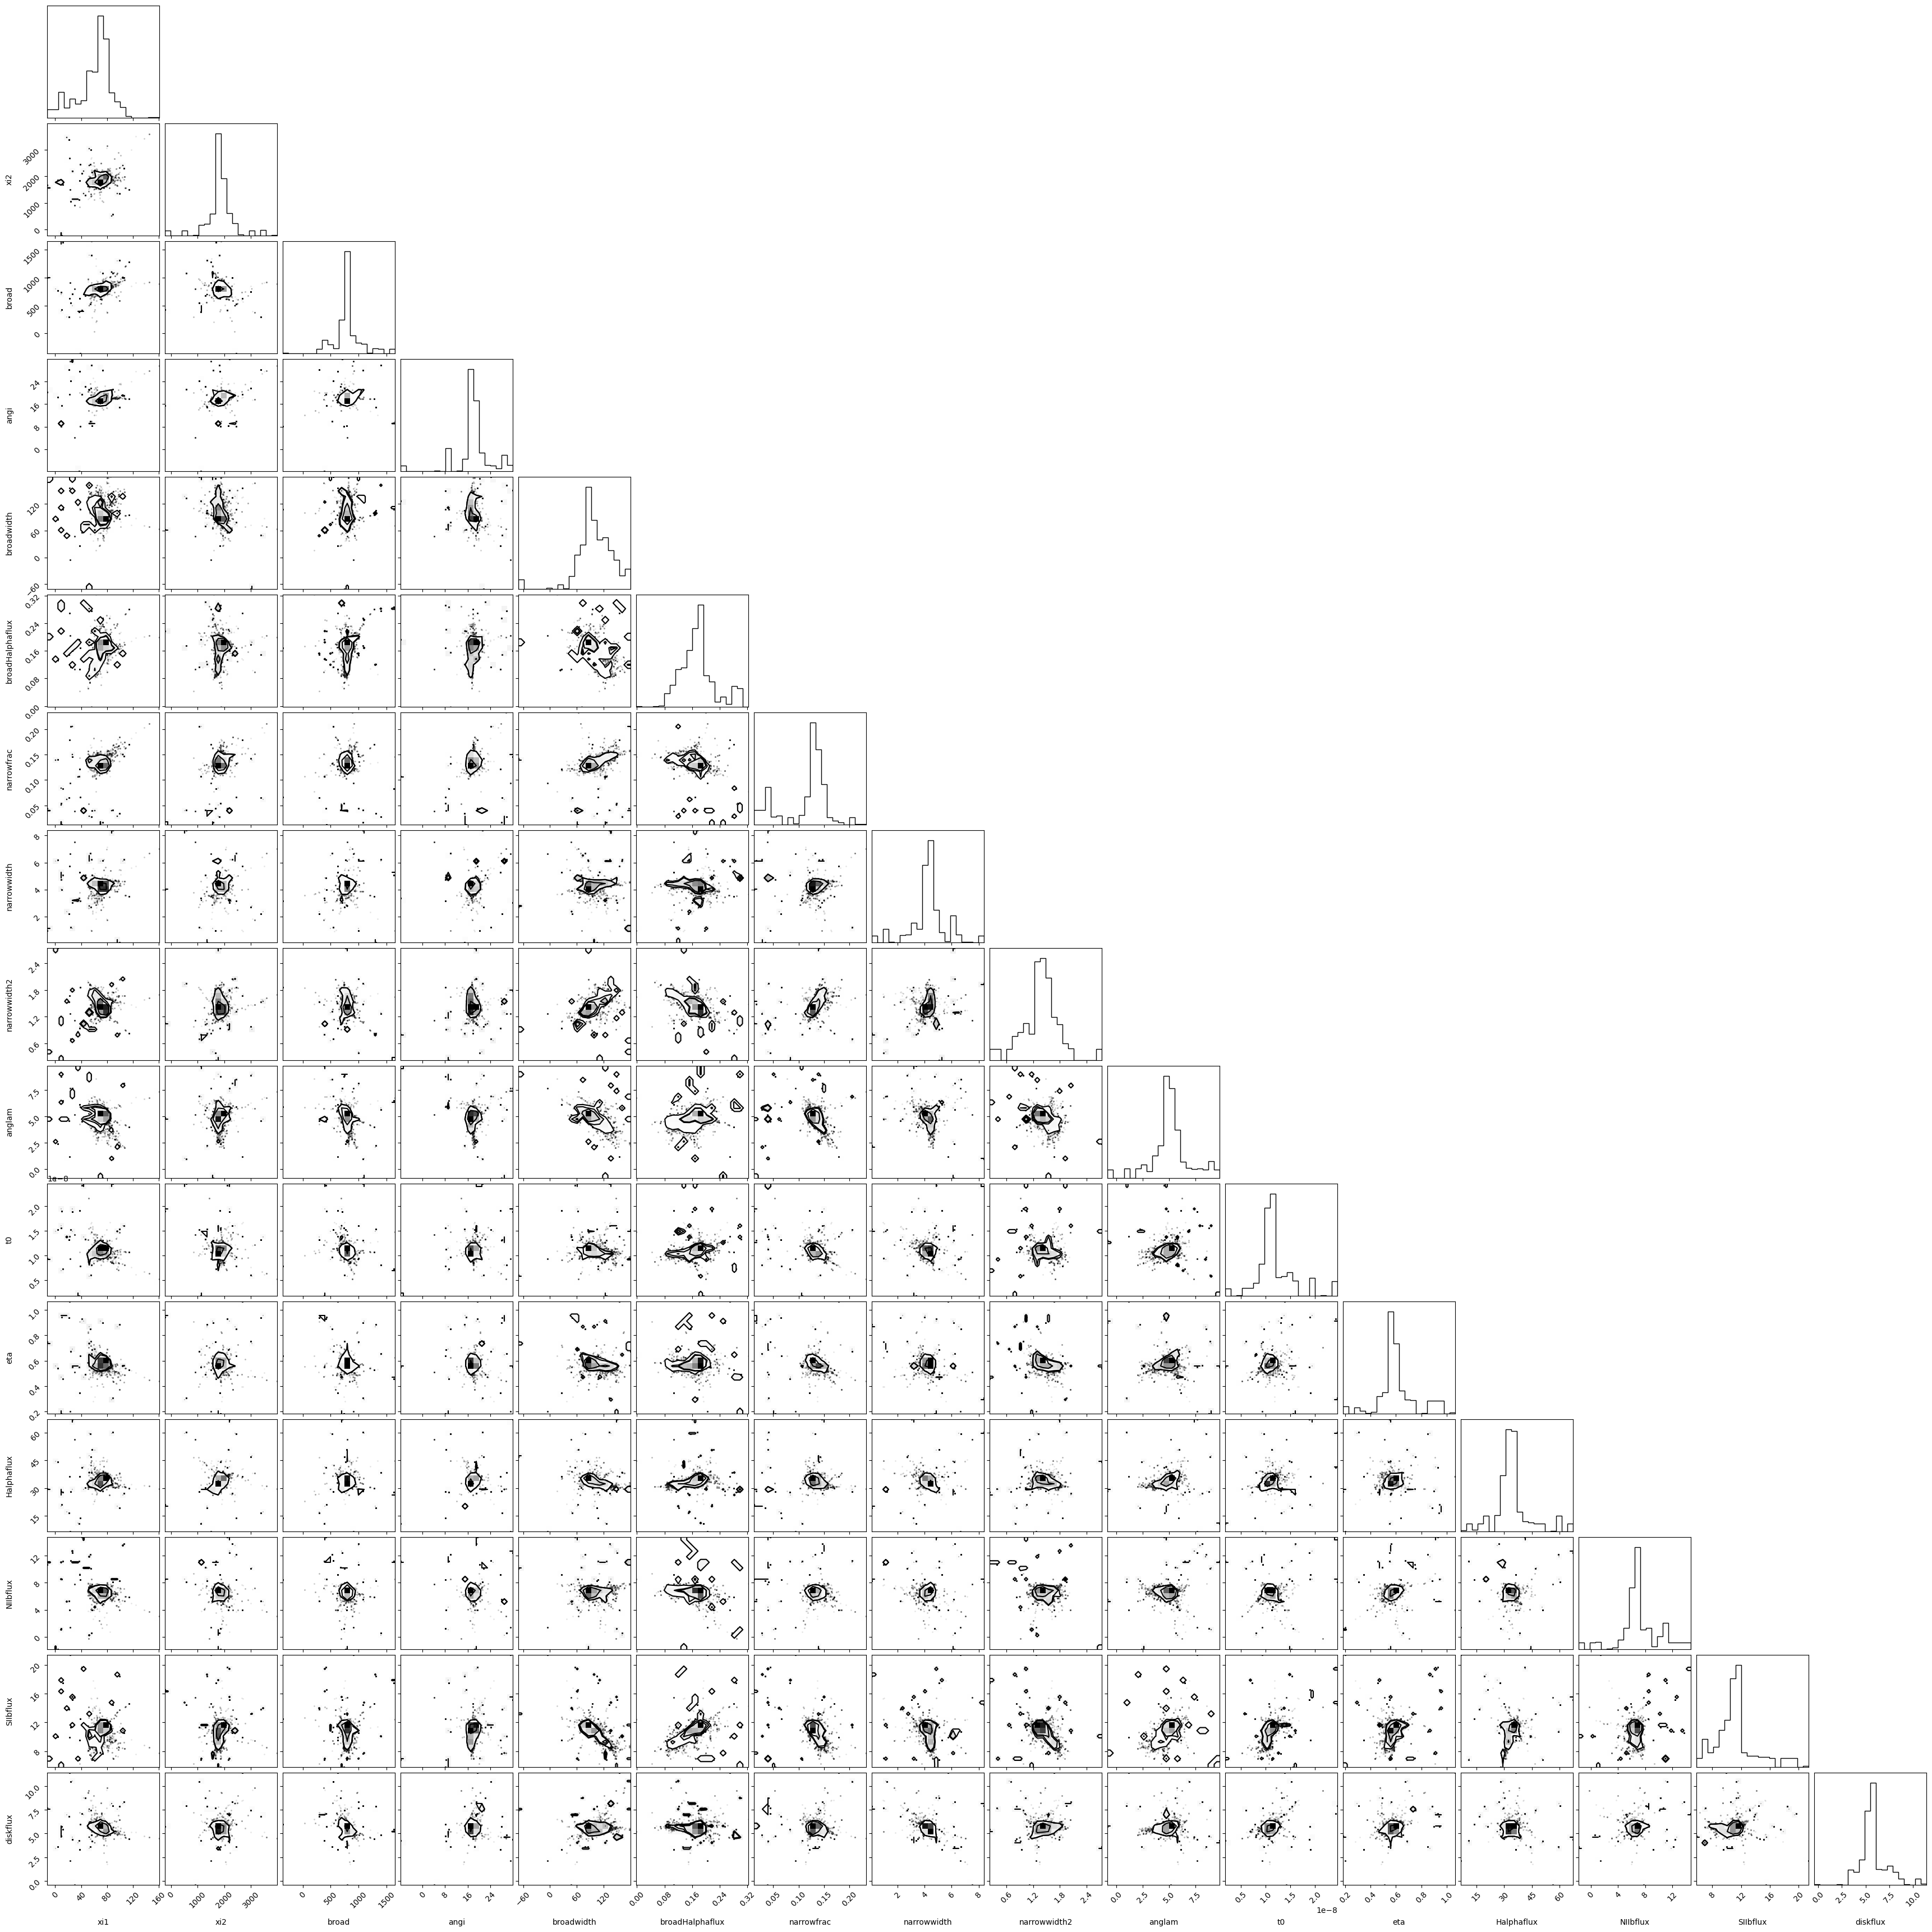

In [37]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

Plot the sampler chains 

<Figure size 600x600 with 0 Axes>

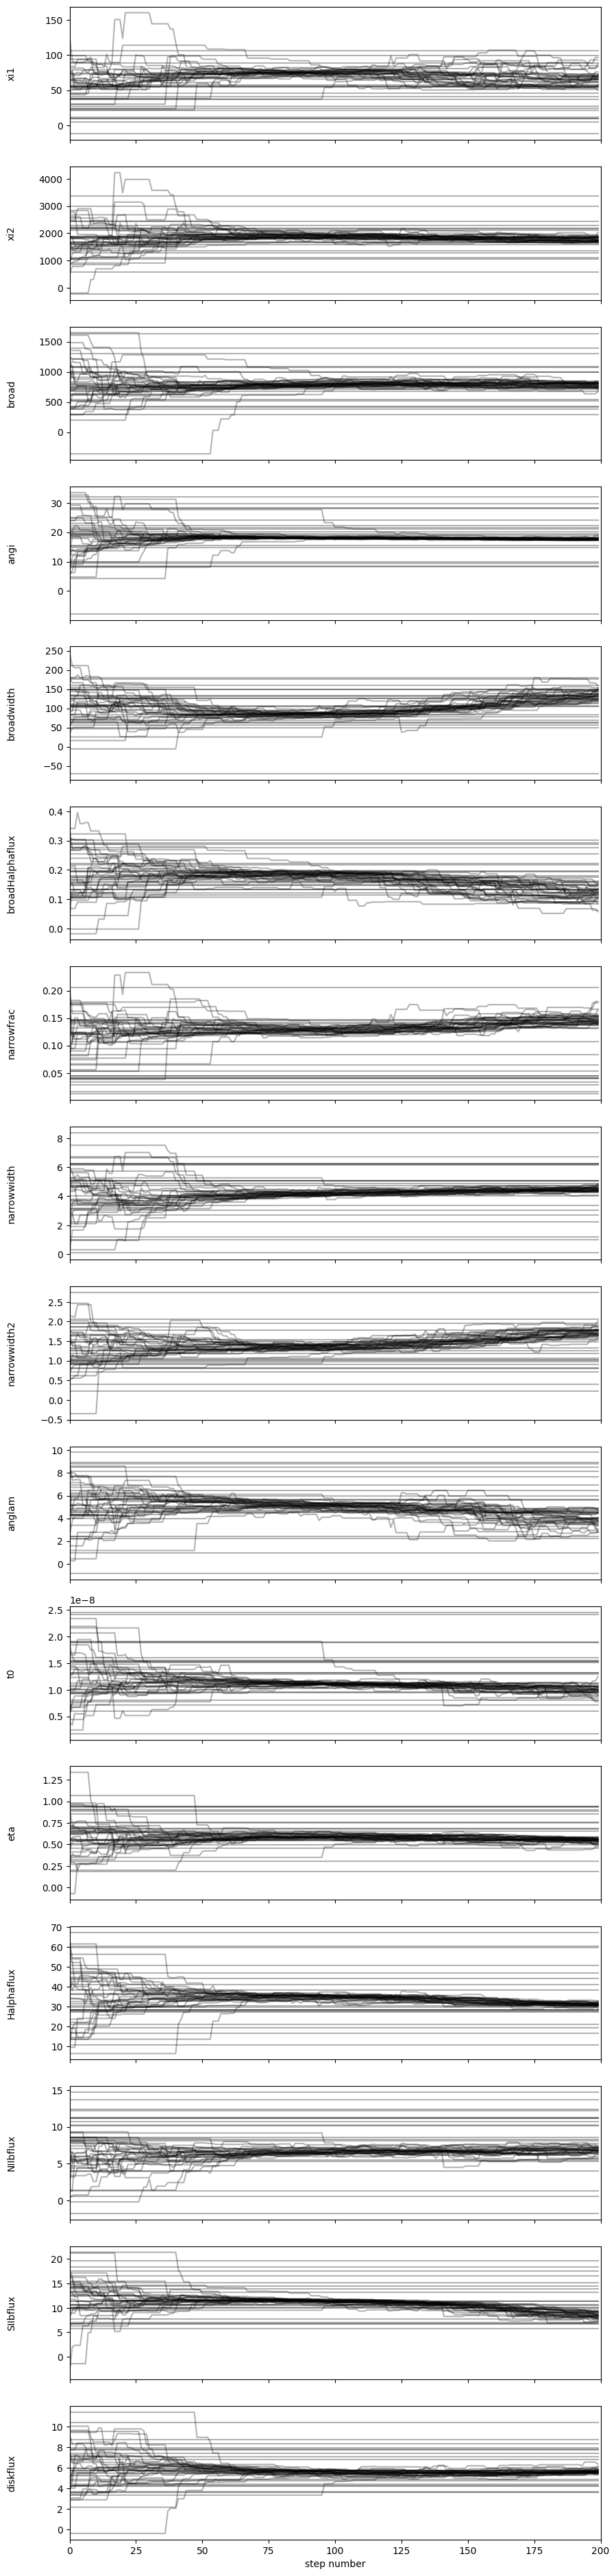

<Figure size 640x480 with 0 Axes>

In [38]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()
plt.clf()

Plot the range of good fits found by the sampler

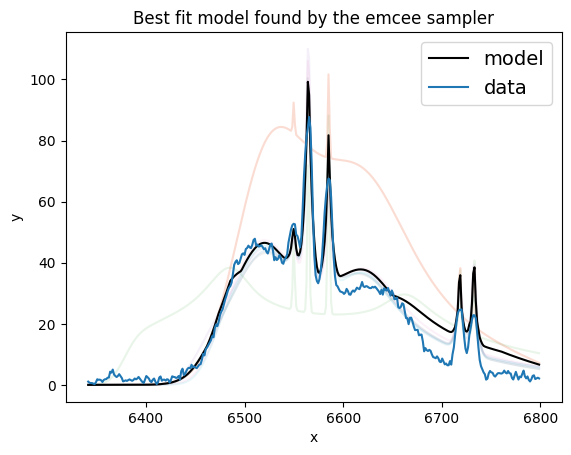

<Figure size 640x480 with 0 Axes>

In [39]:
from ultranest.plot import PredictionBand
band = PredictionBand(wl/(1+fixed['z']))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    try:
        modelfit = lp.test(sample)
        band.add(modelfit)
        plt.plot(wl/(1+fixed['z']),modelfit,alpha=0.1)
    except:
        continue
band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2);

plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.clf()